
<h1 align="center"> CSE 164 Assignment 3, Spring 2023


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



<h2 align="center"> 6 Questions, 50 pts, due: 23:59 pm, May 25th, 2023
    
    Your name: Raja Kumar         Student ID: 2005765

## Instruction 

- In this assignment, you will learn how to extract Lucas-Kanade Optical Flow, how to segment a image using mean shift, and how to build a simple neural network.
    - **Problem 1: Lucas-Kanade Optical Flow (10 points)**
        - Implement the `opticalFlow` function.
    - **Problem 2: Get neighbors (8 points)**
        - Implement the `get_neighbors` function.
    - **Problem 3: Mean Shift (8 points)**
        - Implement the `mean_shift` function.
    - **Problem 4: Segmentation (4 points)**
        - Implement the `segmentation` function.
    - **Problem 5: Build a Neural Network (10 points)**
        - Implement the `build_model` function.
    - **Problem 6: Train a Neural Network (10 points)**
        - Implement the `train_model` function.

- Your job is to implement the sections marked with TODO to complete the tasks.

- Submit your assignments onto **Canvas** by the due date. Upload a <code>zip</code> file containing:

    (1) The saved/latest <code>.ipynb</code> file including the output of all cells.
    
## Note
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged. 
- Don't use any magic function from other libraries. You will get **no credit** if an optical_flow from a known library is used when you are asked to implement "optical_flow" from scratch.
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with less than 5 lines of codes.
- Make sure you have installed required packages: <code>numpy</code>, <code>matplotlib</code>, <code>PIL</code>, <code>opencv</code>, <code>scipy</code>, <code>scikit-learn</code>, <code>scikit-image</code>, <code>tensorflow</code>, <code>h5py</code>. The code is tested with <code>tensorflow==2.8.0</code> and <code>h5py==3.6.0</code>, but it is possible that this code can run with other versions. 

## Objective 

- **Task 1:** Lucas-Kanade Optical Flow
- **Task 2:** Mean Shift Image Segmentation
- **Task 3:** Neural Network

Load the Dependencies
-----

In [2]:
import cv2
import numpy as np
from skimage import io
import requests
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from collections import OrderedDict
import pandas as pd
import scipy.io as sio
import sys
import math

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from tensorflow import keras
from scipy.io import loadmat
import numpy as np     
import h5py                                       

Problem 1: Lucas-Kanade Optical Flow (10 points)
-----

> Lucas-Kanade method is basically an estimate of the movement of interesting
features in successive images of a scene. 

> Lucas-Kanade assumes that (a) the intensity of the pixel does not change when it moves from frame1 to frame2 (b) small motion (c) motion field and optical flow is constant within a small neighborhood.

Implement the **opticalFlow** function below.


In [3]:
def inRange(coordinates, limits):
    ''' 
    inRange checks whether the given cordinates line in the given image limits
    cordinates, limits are tuples i.e., (X,Y) 
    '''
    x,y = coordinates
    X_Limit, Y_Limit = limits
    return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

In [4]:
def opticalFlow(old_frame, new_frame, window_size, min_quality=0.01):
    '''
    OpticalFlow calculates the displacements in X and Y directions i.e., (u,v)
    given two consecutive images varying with time

    Input:
        old_frame: Image from time T. shape (m,n)
        new_frame: Image from time T+1. shape (m,n)
        window_size: the window size in which the Lucas-Kanade assumption holds. int
        min_quality; controls what features we want to track. int
    Output:
        dst_img: destination image, shape (m, n, 3)
    
    TODO: Implement the computation of u,v 
    '''
    max_corners = 10000
    min_distance = 0.1
    # Corners are better points to be tracked. 
    # Here we call OpenCV implemented Shi-Tomasi algorithm to find some corner points
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)

    w = int(window_size/2)

    old_frame = old_frame / 255
    new_frame = new_frame / 255
    
    
    ################## Your code begins here #####################
    #Convolve to get gradients w.r.to X, Y and T dimensions
    kernel_x = np.array([[-1,1],[-1,1]])
    kernel_y = np.array([[-1,-1],[1,1]])
    kernel_t = np.array([[1,1],[1,1]])
    ################## Your code ends here #####################
    
    fx_old = cv2.filter2D(old_frame, -1, kernel_x)              #Gradient over X for old frame
    fy_old = cv2.filter2D(old_frame, -1, kernel_y)              #Gradient over Y for old frame
    fx_new = cv2.filter2D(new_frame, -1, kernel_x)              #Gradient over X for new frame
    fy_new = cv2.filter2D(new_frame, -1, kernel_y)              #Gradient over Y for new frame
    
    fx = (fx_old + fx_new) / 2.0
    fy = (fy_old + fy_new) / 2.0
    
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)  #Gradient over Time

    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:        #   for every corner
            j, i = feature.ravel()		#   get cordinates of the corners (i,j). They are stored in the order j, i
            i, j = int(i), int(j)		#   i,j are floats initially

            I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            b = np.reshape(I_t, (I_t.shape[0],1))
            A = np.vstack((I_x, I_y)).T

            # print(A.shape)
            # print(b.shape)
            # print(A)
            ################## Your code begins here #####################
            # Solving for (u,v)
            const = np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T)
            U = np.matmul(const,b)
            ################## Your code ends here #####################

            u[i,j] = U[0][0]
            v[i,j] = U[1][0]

    return (u,v)


def drawSeperately(old_frame, new_frame, U, V):
    '''
    Create a plot of the displacement vectors given (u,v) and plot the two images and displacement in a row.
    '''
    print(U.shape)
    print(V.shape)
    displacement = np.ones_like(new_frame)            #Fill the displacement plot with White background
    displacement.fill(255.)
    line_color =  (0, 0, 0)
    # draw the displacement vectors
    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            start_pixel = (i,j)
            end_pixel = ( int(i+U[i][j]), int(j+V[i][j]) )
            #check if there is displacement for the corner and endpoint is in range
            if U[i][j] and V[i][j] and inRange( end_pixel, old_frame.shape ):     
                displacement = cv2.arrowedLine( displacement, start_pixel, end_pixel, line_color, thickness =1,tipLength=0.2, line_type=cv2.LINE_AA)

    figure, axes = plt.subplots(1,3,figsize=(30, 30))
    axes[0].imshow(old_frame, cmap = "gray")
    axes[0].set_title("first image")
    axes[1].imshow(new_frame, cmap = "gray")
    axes[1].set_title("second image")
    axes[2].imshow(displacement, cmap = "gray")
    axes[2].set_title("displacements")
    figure.tight_layout()
    plt.show()

image1 shape: (480, 640)
image2 shape: (480, 640)


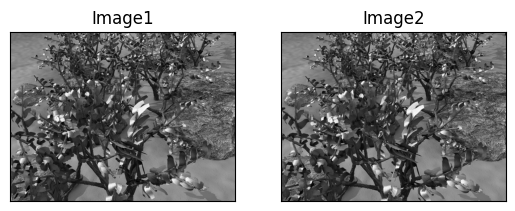

In [7]:

img1 = Image.open(r"grove1.png")
img1 = np.array(img1)
print(f'image1 shape: {img1.shape}')
img2 = Image.open(r"grove2.png")
img2 = np.array(img2)
print(f'image2 shape: {img2.shape}')
plt.subplot(121),plt.imshow(img1, cmap="gray"),plt.title('Image1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2, cmap="gray"),plt.title('Image2')
plt.xticks([]), plt.yticks([])
plt.show()

(480, 640)
(480, 640)


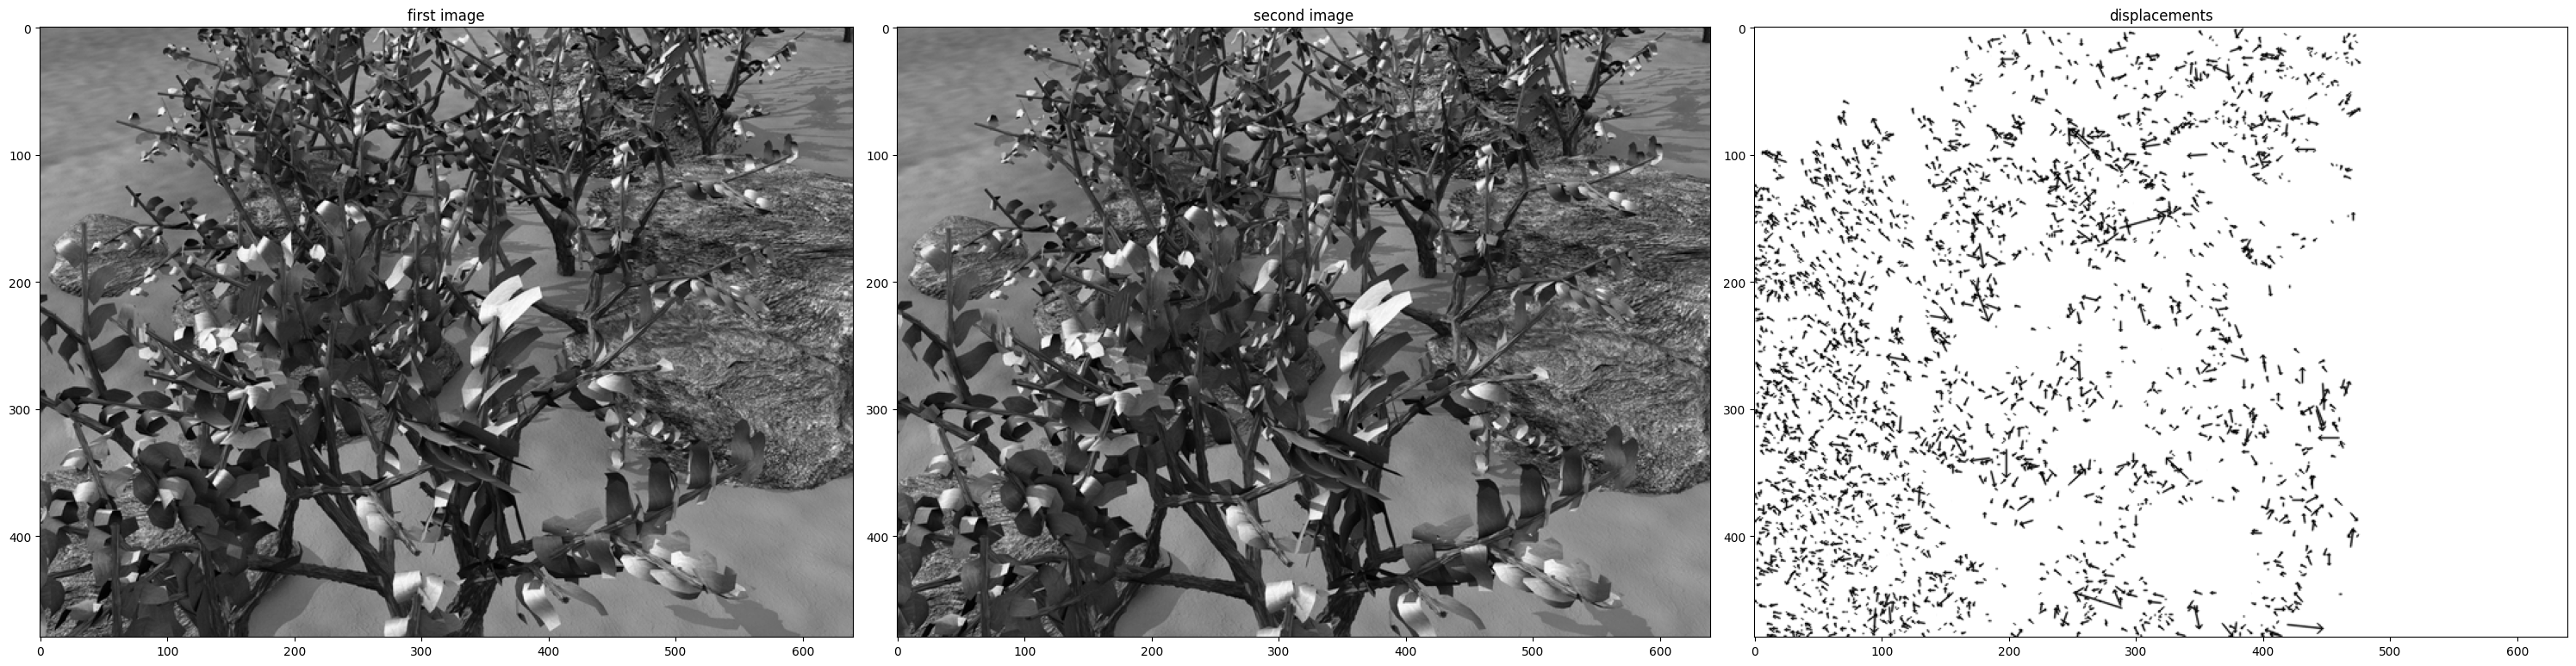

In [8]:
# Obtain (u,v) from Lucas Kanade's optical flow approach
U, V = opticalFlow(img1, img2, 3, 0.05)

# Save results
drawSeperately(img1, img2, U, V)

Mean Shift Setup
-----

Before we start image segmentation with mean shift aigorithm, first we need to define some global variables and utility functions.

In [9]:
# global variables
MIN_DISTANCE = 5
GROUP_DISTANCE = 10
COLOR_POOL = [[1,50,200],[150,200,9],[255,0,0],[10,79,0],\
			  [200,100,0],[25,38,0],[78,250,250],[158,143,120],[28,222,98],\
			  [255,250,199],[100,150,100],[200,50,1],[250,250,78],[15,38,245],\
			  [123,234,90]]

Problem 2: Get neighbors (8 points)
=========

You should finish the **get_neighbors** function. It computes neighbors within a certain radius of the center point.


In [11]:
def euclidean_distance(x1, x2):
	# weighted on the distance more
	dis = (sum((x1[:2] - x2[:2])**2))*1.5
	color = sum((x1[2:] - x2[2:])**2)
	return np.sqrt(dis + color)

# formula: (1/(sigma*sqrt(2*pi)))*e^(-x^2/(2*sigma^2))
def gaussian(distance, sigma):
	return (1/(sigma*math.sqrt(2*math.pi)))*np.exp(-0.5*((distance/sigma))**2)
 
def get_neighbors(all_points, center_point, sigma):
    '''
    Given a center point and a list of all points, returns a list of neighbors within a certain radius of the center point
    Input:
        all_points: A list of all points. Each point is a 1D numpy array of shape (5,) representing (x,y,r,g,b)
        center_point: The center of the window. A 1D numpy array of shape (5,) representing (x,y,r,g,b)
        sigma: The standard deviation of the Gaussian function used for weighting. A float value.
    Output:
        neighbors: A list of neighboring points. Each point is a 1D numpy array of shape (5,) representing (x,y,r,g,b)
    
    TODO: Implement the computation of neighbors within a certain radius (sigma) of the center point
    '''
    neighbors = []
    ################## Your code begins here #####################  
    # hint: use euclidean_distance function to evaluate whether a point is a neighbor  
    for point in all_points:
      curr_dist = euclidean_distance(point, center_point)
      if (curr_dist <= sigma):
        neighbors.append(point)
    ################## Your code ends here #####################            
    return neighbors


def find_min_dis(group, pos):
	min_distance = sys.float_info.max
	for p in group:
		min_distance = min(min_distance, euclidean_distance(p, pos));
	return min_distance

The **move** function deals with a center point, points within a certain window of center point, and standard deviation of the gaussian function for weighted averaging. It computes a new centroid by using weighted average of all the points within a centain window.


In [12]:

def move(center_point, points, sigma):
	'''
    Computes the weighted mean of the density in the window determined by the Gaussian kernel
	(sum of gaussian(distance)*point) / (sum of gaussian(distance))

    Input:
        center_point: The center of the window. shape(5, ). contains x,y,r,g,b
        points: A list of points in the window. each element if of shape(5, ), containing contains x,y,r,g,b
        sigma: The standard deviation of gaussian function. float
    Output:
        new_center_point: The new center of the window. shape(5, ). contains x,y,r,g,b
    '''
	sum_x = 0
	sum_y = 0
	sum_r = 0
	sum_g = 0
	sum_b = 0
	sum_weight = 0

	for p in points:
		distance = euclidean_distance(p, center_point)
		weight = gaussian(distance, sigma)

		sum_x += weight * p[0]
		sum_y += weight * p[1]
		sum_r += weight * p[2]
		sum_g += weight * p[3]
		sum_b += weight * p[4]
		sum_weight += weight

	return np.array([(sum_x / sum_weight), (sum_y / sum_weight), \
		(sum_r / sum_weight), (sum_g / sum_weight), (sum_b / sum_weight)])

Group Results
-----

There is no guarantee that two different points will eventually converge to exactly the same mode. In fact, in practice that barely happens. Thus, two converged centroids that are close enough are classified as belonging to the same cluster. 

In [13]:
def group_clusters(positions, points):
	# label each original points
	labels = [0]
	# a list to group the positions, for the purpose of calculating the min distance
	grouped_positions = [[positions[0]]]
	# a list to group the original points
	# once we know the lable of the original point, we can quickly find other elements in the same group
	grouped_points = [np.array([points[0]])]
	total_index = 1
	for i in range(1, len(positions)):
		need_new_index = True
		for index, group in enumerate(grouped_positions):
			if find_min_dis(group, positions[i]) <= GROUP_DISTANCE:
				labels.append(index)
				grouped_positions[index].append(positions[i])
				grouped_points[index] = np.vstack([grouped_points[index], points[i]])
				need_new_index = False
				break
		if need_new_index:
			labels.append(total_index)
			grouped_positions.append([positions[i]])
			grouped_points.append(np.array([points[i]]))
			total_index += 1

	return labels, np.array(grouped_points)

Problem 3: Mean Shift (8 points)
=========

You should finish the **mean_shift** function. It implements the main logic of mean shift algorithm.


In [14]:
def mean_shift(points, sigma):
	'''
    Mean shift main function. Calls previous functions to finish mean shift segmentation.

    Input:
        points: shape (m, 5). each row is the concatenation of pixel coordinates x,y and pixel values r,g,b
        sigma: The standard deviation of gaussian function. float
    Output:
        labels: a list of indices of cluster to which each pixel belongs to
		grouped_points: shape (g, n, 5), where g is the number of clusters, 
		n is the pixel numbers in each cluster, 5 gor x,y,r,g,b
		
	 TODO: Implement the mean_shift function
    '''
	# we mark a point as visited when it is converged(measured by distance)
	# type: {tuple: boolean}
	visited = OrderedDict((tuple(p), False) for p in points)

	# mapping from the original points to points after shifted
	# type: {tuple: ndarray}
	original_to_shifted = OrderedDict((tuple(p), p) for p in points)

	converged = False
	iteration = 0																										

	# if not all points have converged
	while not converged and iteration < 30: 
		converged = True
		for original_point in original_to_shifted:
			cur_pos = original_to_shifted[original_point]
			if visited[tuple(cur_pos)]:
				continue
			################## Your code begins here #####################
			neighbors = get_neighbors(points, cur_pos, sigma)
			next_pos = move(cur_pos, neighbors, sigma)
			original_to_shifted[original_point] = next_pos
			eud_dist = euclidean_distance(cur_pos, next_pos)
			#distance_dif = gaussian(eud_dist, sigma)
			################## Your code ends here #####################
			if eud_dist <= sigma:
				visited[tuple(next_pos)] = True
			else:
				visited[tuple(next_pos)] = False
				converged = False
		iteration += 1

	positions = list(original_to_shifted.values())

	# after all ponits are converge d, we group and label the clusters
	labels, grouped_points = group_clusters(positions, points)

	return labels, grouped_points

Problem 3: Segmentation (4 points)
=========

You should finish the **segmentation** function. It implements the clustering.


In [15]:
def segmentation(image, points, width, height):

    '''
        Image Segmentation Function. Segments an input image into regions using mean shift algorithm.
    
    Input:
            image: the input image to be segmented
            points: an array of shape (n, 2) representing the initial seed points for mean shift
            width: the desired width of the output image
            height: the desired height of the output image
    Output:
            new_image_resized: the segmented output image of size (width, height)
    TODO: Implement the segmentation function
    '''    
    labels, shifted_points = mean_shift(points, 5)
    # The list of shifted_points contains pixel clusters, where all pixels in a cluster share the same mode.
    
    new_image = np.zeros_like(image)
    for pts in shifted_points:
        avg_rgb = np.average(pts[:,2:], axis=0)
        for point in pts:
            ################## Your code begins here #####################
            # Reminder: the images are displaying in (width,height,channel), but in Numpy array the order is (hight,width,channel)
            x,y,r,g,b = point[0], point[1], point[2], point[3], point[4]
            #print(new_image.shape)
            new_image[x,y,:] = avg_rgb

            ################## Your code ends here #####################

    new_image_resized = cv2.resize(new_image,(width,height),interpolation=cv2.INTER_CUBIC)
    return shifted_points,new_image_resized


def cluster_visualization(image,shifted_points,width,height):
    # Visualizing the segmentation for the three largest clusters
    num_sets = 3 # number of sets to draw
    sorted_sets = sorted(shifted_points, key=lambda s: len(s), reverse=True)[:num_sets] # get the top 20 sets
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)] # list of colors
    new_image = np.zeros_like(image) # black image
    for i, pts in enumerate(sorted_sets):
        color = colors[i % len(colors)] # cycle through colors if there are more sets than colors
        for point in pts:
            x = point[1]
            y = point[0]
            new_image[y, x] = color # set the color for each point in the set
    segmentation_visualization = cv2.resize(new_image, (width, height), interpolation=cv2.INTER_CUBIC)
    return segmentation_visualization

image shape: (129, 129, 3)


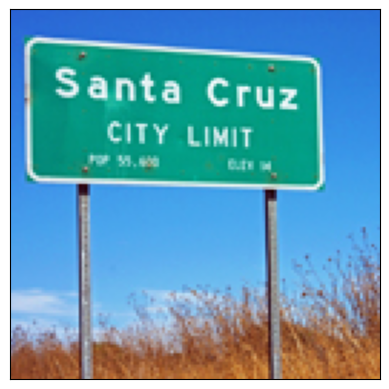

In [16]:
#url = "https://studentsuccess.ucsc.edu/students-as-parents/images/sammy-slug-251x325.jpg"  
url = "https://www.ucsc.edu/visit/images/virtual-tour2-129.jpg"
image = io.imread(url)
original_height = int(image.shape[0])
original_width = int(image.shape[1])
print(f'image shape: {image.shape}')
plt.xticks([]), plt.yticks([])
plt.imshow(image)

Test the **segmentation** function. 

<ipython-input-13-18b9e807a909>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return labels, np.array(grouped_points)


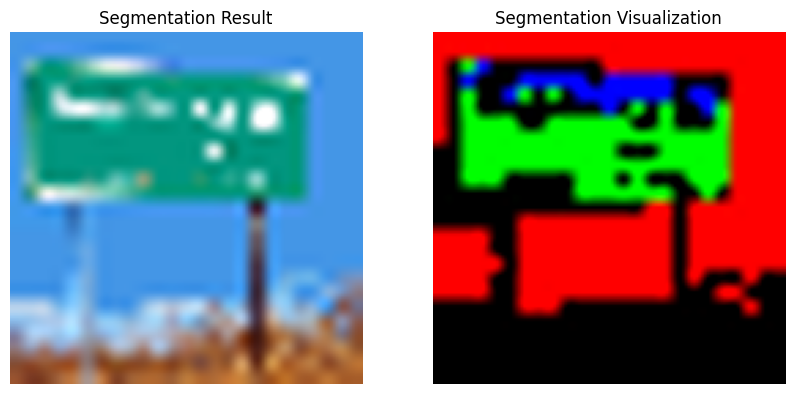

In [17]:
# resize to a smaller size to reduce computational cost
# Generally, the larger the resolution, the better the result, and the longer it takes
image = cv2.resize(image,(int(original_height/5),int(original_width/5)),interpolation=cv2.INTER_CUBIC)
all_points = []

for i in range(0, image.shape[0]):
  for j in range(0, image.shape[1]):
    all_points.append(np.array([i,j] + list(image[i,j]))) 

shifted_points,segmented_image = segmentation(image, all_points, original_width, original_height)
cluster_visualization = cluster_visualization(image,shifted_points,original_width,original_height)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(segmented_image)
axs[0].set_title('Segmentation Result')
axs[0].axis('off')

axs[1].imshow(cluster_visualization)
axs[1].set_title('Segmentation Visualization')
axs[1].axis('off')

# show the plot
plt.show()

Neural Network Setup
-----

Before we start building a neural network, first we need to load the dataset and split it into train/val/test set. Here we use Street View House Numbers (SVHN) dataset, which is a digit classification benchmark dataset that contains 600,000 32×32 RGB images of printed digits (from 0 to 9) cropped from pictures of house number plates. 

In [ ]:
%cd "/content/drive/MyDrive/MS/spring2023/CSE164/Assignment3"

/content/drive/MyDrive/MS/spring2023/CSE164/Assignment3


In [ ]:
val_size = 10000
# download SVHN_train.hdf5 and SVHN_test.hdf5 from https://drive.google.com/file/d/17Ros6RTqPUN_SCEmJT_eiuLx3OOpbPOU/view?usp=sharing, https://drive.google.com/file/d/1VHMJk0PfJnVsvgCqoV_HhSGD9E7iM8QE/view?usp=sharing
with h5py.File('SVHN_train.hdf5', 'r') as f:
    shape = f["X"].shape
    x_train = f["X"][:shape[0]-val_size]
    y_train = f["Y"][:shape[0]-val_size].flatten()
    x_val = f["X"][shape[0]-val_size:]
    y_val = f["Y"][shape[0] - val_size:].flatten()

with h5py.File('SVHN_test.hdf5', 'r') as f:
    x_test = f["X"][:]
    y_test = f["Y"][:].flatten()

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In [ ]:
x_train.shape

(63257, 32, 32, 3)

Problem 4: Build a Neural Network (10 points)
=========

Build your convolutional neural networks by adding some layers. You should use 4 convolution layers and ReLU as the default activation function. The kernel size of both layers should be 3x3. Use 32 and 64 as the number of filters for the first and the second convolutional layers, respectively. Use 128 as the number of filters for two last convolution layers, and 3x3 as the kernel size.After that, flatten your input and add two more dense layers. There should be 1024 units in the first dense with ReLU activation, and use 10 hidden units in the second dense layer with softmax activation. 



In [ ]:

def build_model():
    '''
    add multiple layers as instructed to the model.

    Output:
        a keras neural network model with certain layers.
    
    TODO: Implement the build_model function
    '''
    model = tf.keras.models.Sequential()

    ################## Your code begins here #####################
    # Add layers
    # call model.add multiplpe times until all necessary layers are added

    # Layer
    model.add(keras.Input(shape=(32,32,3)))
    model.add(keras.layers.Conv2D(32,3,activation='relu'))
    model.add(keras.layers.Conv2D(64,3,activation='relu'))
    model.add(keras.layers.Conv2D(128,3,activation='relu'))
    model.add(keras.layers.Conv2D(128,3,activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    # Layer

    ################## Your code ends here #####################

    return model


Problem 5: Train a Neural Network (10 points)
=========

Compile model here and set your initial hyperparameters. Use SGD as the optimizer with initial learning rate 0.01 and the momentum = 0.9. You could choose 'categorical_crossentropy' as your loss function, and the metrics should be 'accuracy'. After that, train your model for 10 epochs. 

In [ ]:
#loss=tf.keras.losses.CategoricalCrossentropy(),
def train_model(model):
    '''
    Define the optimizer, compile model, and train the model.
    
    TODO: Implement the train_model function
    '''
    ################## Your code ends here #####################
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # use model.fit for training
    model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

    ################## Your code ends here #####################

In [ ]:
model = build_model()
model.summary()
train_model(model)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_loss, test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              75498496  
                                                                 
 dense_3 (Dense)             (None, 10)               